In [31]:
## Importy i użyteczne wyrażenie lambda
import bisect
import math
import numpy as np
import pandas as pd
import matplotlib as plt 
sign = lambda x: (1, -1)[x < 0]

## Początek definicji klasy
class PQuantile:
    def __init__(self, b, discount_factor):
        ## Konstruktor
        self.num_obs = 0 ## Liczba obserwacji
        ## Liczba wartości mniejszych lub równych danemu kwantylowi
        self.n = [i for i in range(b+1)]
        self.q = [] ## Wartości kwantyli
        ## b to liczba kwantyli, włączając w to zerowy i setny
        ## (min i max) kwantyl
        self.b = b
        ## Współczynnik dyskontujący, który określa, w jaki sposób
        ## korygujemy wcześniejsze wartości po pojawieniu się nowych
        self.discount_factor = discount_factor
        
    def next_obs(self, x):
        if self.num_obs < (self.b + 1):
            self.q.append(x)
            self.q.sort()
            self.num_obs = self.num_obs + 1
        else:
            self.next_obs2(x) 
            self.next_obs = self.next_obs2
    
    def next_obs2(self, x):
        ## Zmniejszanie liczby obserwacji
        if self.num_obs > self.b * 10:
            corrected_obs = max(self.discount_factor * self.num_obs,
                                self.b)
            self.num_obs = corrected_obs + 1
            self.n = [math.ceil(nn * self.discount_factor)
                      for nn in self.n]
            for i in range(len(self.n) - 1):
                if self.n[i + 1] - self.n[i] == 0:
                    self.n[ i + 1] = self.n[i + 1] + 1
                elif self.n[i + 1] < self.n[1]:
                    ## W praktyce taka sytuacja wydaje się nie występować
                    self.n[i + 1] = self.n[i] - self.n[i + 1] + 1
        else:
            self.num_obs = self.num_obs + 1

        k = bisect.bisect_left(self.q, x)
        if k is 0:
            self.q[0] = x 
        elif k is self.b+1:
            self.q[-1] = x
            k = self.b
        if k is not 0:
            k = k - 1

        self.n[(k+1):(self.b+1)] = [self.n[i] + 1 
                                    for i in range((k+1),
                                                   (self.b+1))]

        for i in range(1, self.b):
            np = (i)*(self.num_obs - 1 )/(self.b)
            d = np - self.n[i]
            if (d >= 1 and (self.n[i+1] - self.n[i]) > 1):
                self._update_val(i, d)
            elif (d <= -1 and (self.n[i-1] - self.n[i]) < -1):
                self._update_val(i, d)

    ## Ogólna metoda aktualizacji
    ## Jak widzisz, po przesunięciu kwantylu zarówno self.n, jak i self.q są aktualizowane
    def _update_val(self, i, d):
        d = sign(d)
        qp = self._adjust_parabolic(i, d)
        if self.q[i] < qp < self.q[i+1]:
            self.q[i] = qp
        else:
            self.q[i] = self._adjust_linear(i, d)
        self.n[i] = self.n[i] + d

    ## Główna metoda odpowiedzialna za aktualizacje
    def _adjust_parabolic(self, i, d):
        new_val = self.q[i]
        m1 = d/(self.n[i+1] - self.n[i-1])
        s1 = (self.n[i] - self.n[i-1] + d) * (self.q[i+1] - self.q[i]) / (self.n[i+1] - self.n[i])
        
        s2 = (self.n[i+1] - self.n[i] - d) * (self.q[i] - self.q[i-1]) / (self.n[i] - self.n[i-1])
        new_val = new_val + m1 * (s1 + s2) 
        return new_val

    ## Zapasowa metoda na przypadki, w których nie są spełnione warunki
    ## do zastosowania metody parabolicznej
    def _adjust_linear(self, i, d):
        new_val = self.q[i]
        new_val = new_val + d * (self.q[i + d] - self.q[i]) / (self.n[i+d] - self.n[i])
        return new_val


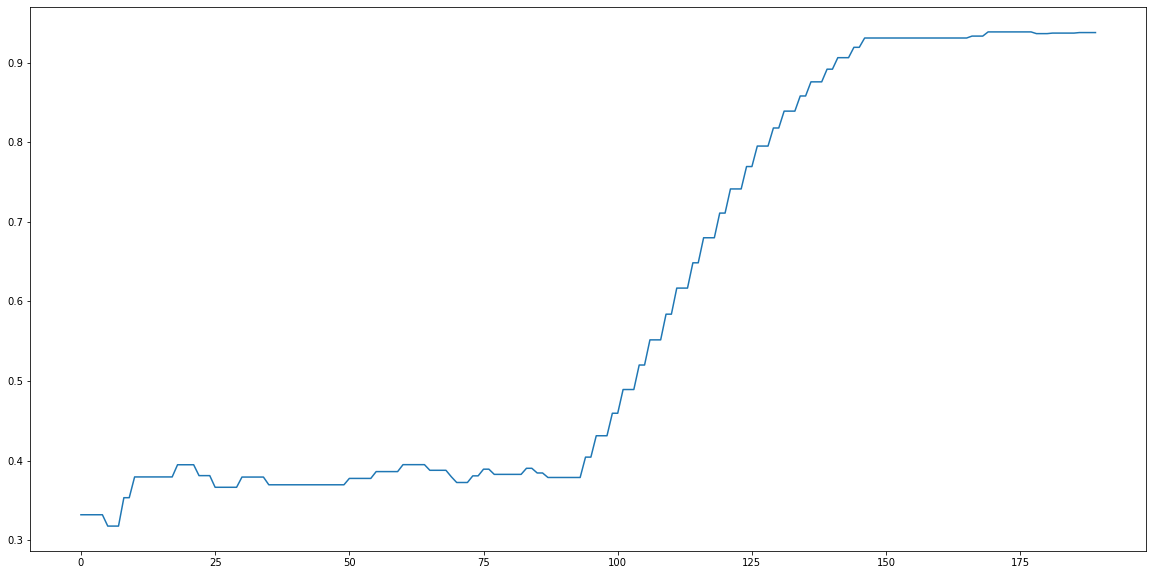

In [32]:
plt.rcParams['figure.figsize'] = [20, 10]
from numpy.random import uniform
import matplotlib.pyplot as plt
qt = PQuantile(10, 0.3)
qt_ests = []
for _ in range(100):
    qt.next_obs(uniform())
    if len(qt.q) > 10:
        qt_ests.append(qt.q[4])
for _ in range(100):
    qt.next_obs(uniform(low = 0.9))
    qt_ests.append(qt.q[4])
    
plt.plot(qt_ests)

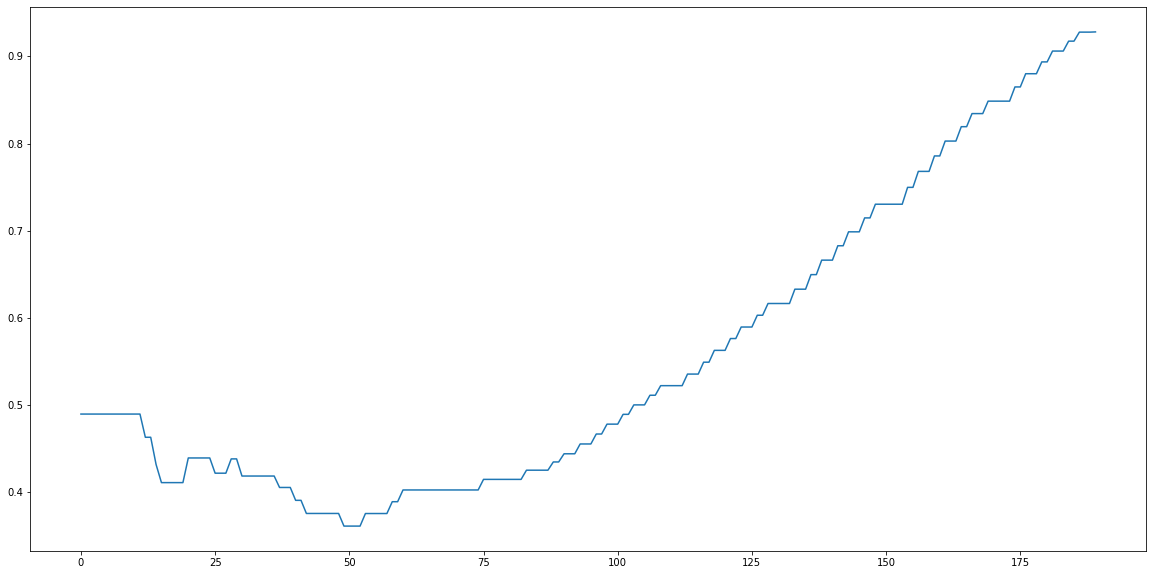

In [33]:
qt = PQuantile(10, 0.8)
qt_ests = []
for _ in range(100): 
    qt.next_obs(uniform()) 
    if len(qt.q) > 10:
        qt_ests.append(qt.q[4])
for _ in range(100):
    qt.next_obs(uniform(low = 0.9))
    qt_ests.append(qt.q[4])
    
plt.plot(qt_ests)

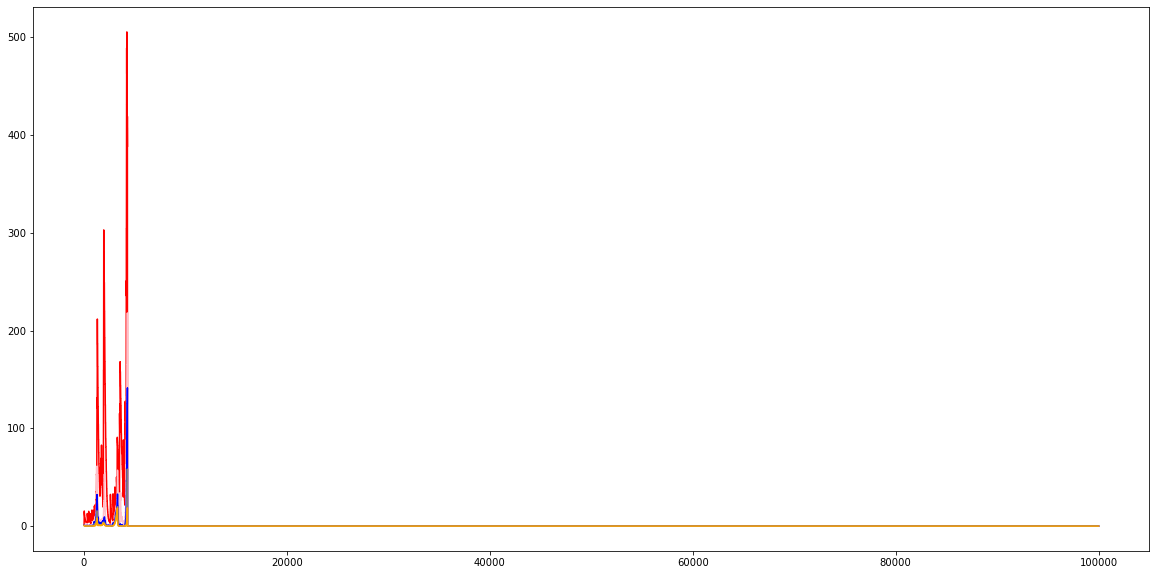

In [34]:


df = pd.read_csv("abridged.df.csv")

nrows = 100000
qt_est1 = np.zeros(nrows)
qt_est2 = np.zeros(nrows)
qt_est3 = np.zeros(nrows)
qt_est4 = np.zeros(nrows)
qt_est5 = np.zeros(nrows)
qt_est6 = np.zeros(nrows)
qt_est7 = np.zeros(nrows)
qt_est8 = np.zeros(nrows)
qt_est9 = np.zeros(nrows)
for idx, val in enumerate(df.LagTime[:nrows]):
    qt.next_obs(val)
    if len(qt.q) > 10:
        qt_est1[idx] = qt.q[1]
        qt_est2[idx] = qt.q[2]
        qt_est3[idx] = qt.q[3]
        qt_est4[idx] = qt.q[4]
        qt_est5[idx] = qt.q[5]
        qt_est6[idx] = qt.q[6]
        qt_est7[idx] = qt.q[7]
        qt_est8[idx] = qt.q[8]
        qt_est9[idx] = qt.q[9]
        
plt.plot(qt_est9, color = 'red')
plt.plot(qt_est7, color = 'pink')
plt.plot(qt_est5, color = 'blue')
plt.plot(qt_est3, color = 'gray')
plt.plot(qt_est2, color = 'orange')